In [1]:
%matplotlib inline
import os.path as op
from glob import glob
from collections import Counter

import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
classes = ['accepted', 'ignored', 'rejected']
ign_codes = ['I005', 'I007', 'I010', 'I011']
rej_codes = ['I002', 'I003', 'I004', 'I006', 'I008', 'I009']
all_codes = sorted(ign_codes + rej_codes)

base_dir = '/scratch/tsalo006/reliability_analysis/tedana_outputs/'

In [3]:
columns = ['label', 'failure', 'duration', 'accepted', 'rejected', 'ignored'] + all_codes
summary_df = pd.DataFrame(columns=columns)

ted_dirs = sorted(glob(op.join(base_dir, 'logging-seed*')))
comptables = sorted(glob(op.join(base_dir, 'sub-*_seed-*_comptable.txt')))
labels = [op.basename(c) for c in comptables]
labels = [c.replace('_comptable.txt', '') for c in labels]

for label in labels:
    sub, seed = label.split('_')
    seed = seed.split('-')[-1]
    if label == labels[0]:
        dn_img = nib.load(op.join(base_dir, '{0}_seed-{1}_denoised.nii'.format(sub, seed)))
        n_trs = dn_img.shape[-1]

    comptable = pd.read_csv(
        op.join(base_dir, '{0}_seed-{1}_comptable.txt'.format(sub, seed)), sep='\t')

    log_df = pd.read_csv(op.join(base_dir, '{0}_seed-{1}_log.tsv'.format(sub, seed)),
                         sep='\t', header=None,
                         names=['time', 'module', 'level', 'message'])
    log_df['time'] = pd.to_datetime(log_df['time'])
    duration = log_df['time'].iloc[-1] - log_df['time'].iloc[0]
    minutes = duration.total_seconds() / 60.
    
    # Number of PCA components
    mess = log_df.loc[log_df['message'].str.contains('components with MLE'), 'message'].values[0]
    n_pca = int([m for m in mess.split() if m.isdigit()][0])
    
    failure = any(log_df['message'].str.contains('ICA failed to converge'))
    rationales = comptable['rationale'].tolist()
    classifications = comptable['classification'].tolist()
    rationales = [[m for m in r.split(';') if m] for r in rationales if isinstance(r, str)]
    rationales = [item for sublist in rationales for item in sublist]
    counter = dict(Counter(rationales))
    counter['subject'] = sub
    counter['seed'] = seed

    counter2 = dict(Counter(classifications))
    for k, v in counter2.items():
        counter[k] = v

    counter['failure'] = failure
    counter['duration'] = minutes
    counter['n pca'] = n_pca
    counter['label'] = label
    summary_df = summary_df.append(counter, ignore_index=True).fillna(0)

In [4]:
summary_df.head()

,label,failure,duration,accepted,rejected,ignored,I002,I003,I004,I005,I006,I007,I008,I009,I010,I011,n pca,seed,subject
0,sub-01_seed-000,False,54.983333,42,153,297,95,58,69,0.0,0.0,290,5.0,5.0,7.0,1.0,492.0,000,sub-01
1,sub-01_seed-001,False,30.733333,41,156,295,92,57,74,0.0,2.0,293,6.0,3.0,2.0,1.0,492.0,001,sub-01
2,sub-01_seed-002,False,27.783333,49,157,286,83,58,86,0.0,1.0,282,4.0,3.0,4.0,0.0,492.0,002,sub-01
3,sub-01_seed-003,False,27.283333,46,159,287,83,52,92,0.0,1.0,282,6.0,2.0,5.0,1.0,492.0,003,sub-01
4,sub-01_seed-004,False,24.200000,44,136,312,72,50,71,0.0,1.0,311,7.0,8.0,1.0,0.0,492.0,004,sub-01


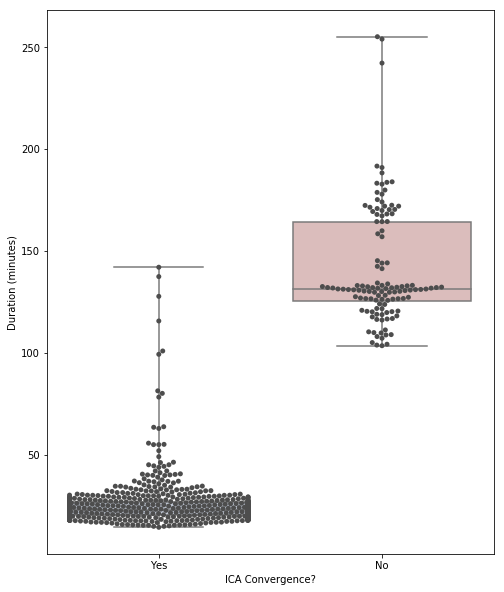

In [5]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="failure", y="duration", data=summary_df,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="failure", y="duration", data=summary_df,
              color=".3", linewidth=0)

ax.set_ylabel('Duration (minutes)')
ax.set_xlabel('ICA Convergence?')
ax.set_xticklabels(['Yes', 'No'])
fig.savefig('run_duration_by_convergence.png')

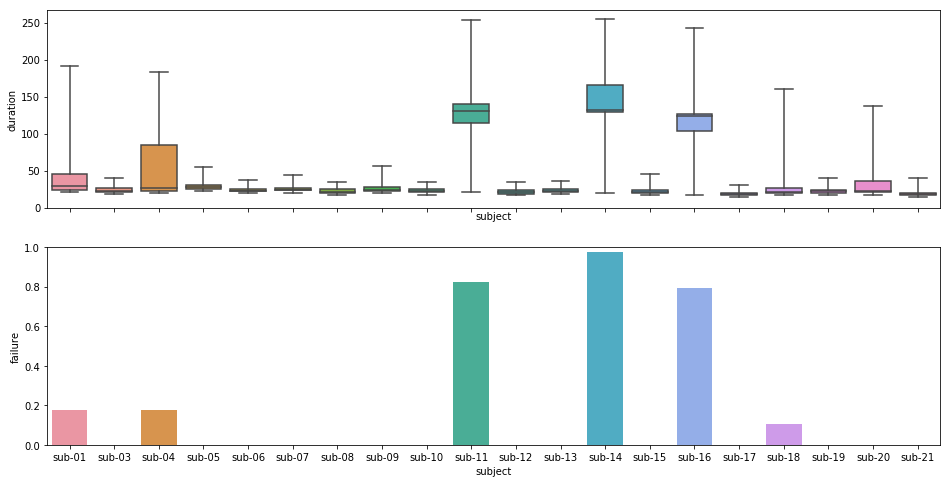

In [6]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(16, 8))
sns.boxplot(x="subject", y="duration", data=summary_df,
            whis="range", ax=axes[0])
axes[0].set_ylim(0, None)
temp_df = summary_df.groupby('subject').mean()
temp_df['subject'] = temp_df.index
sns.barplot(x="subject", y="failure", data=temp_df,
            ax=axes[1])
axes[1].set_ylim(0, 1)
fig.savefig('run_duration_by_subject.png')

/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


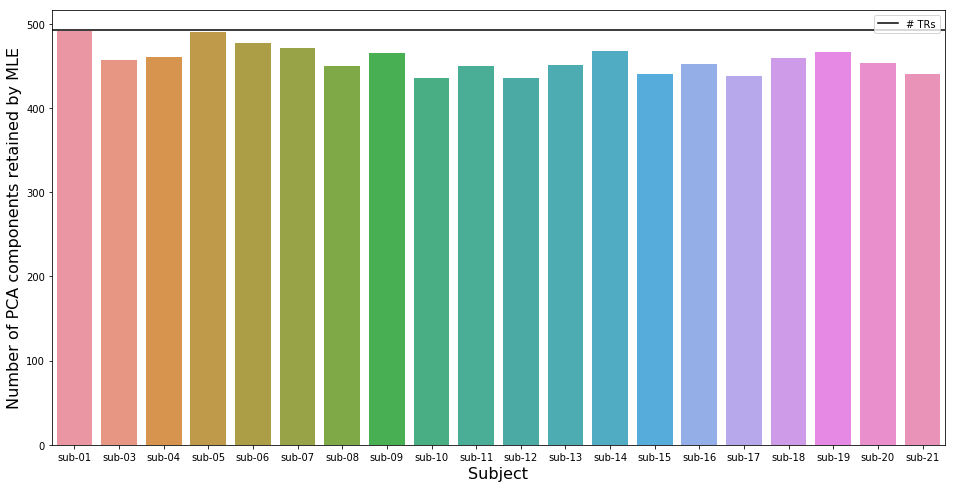

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x="subject", y="n pca", data=summary_df,
            ax=ax)
ax.set_ylabel('Number of PCA components retained by MLE', fontsize=16)
ax.set_xlabel('Subject', fontsize=16)
ax.axhline(n_trs, color='black', label='# TRs')
ax.legend()
fig.show()

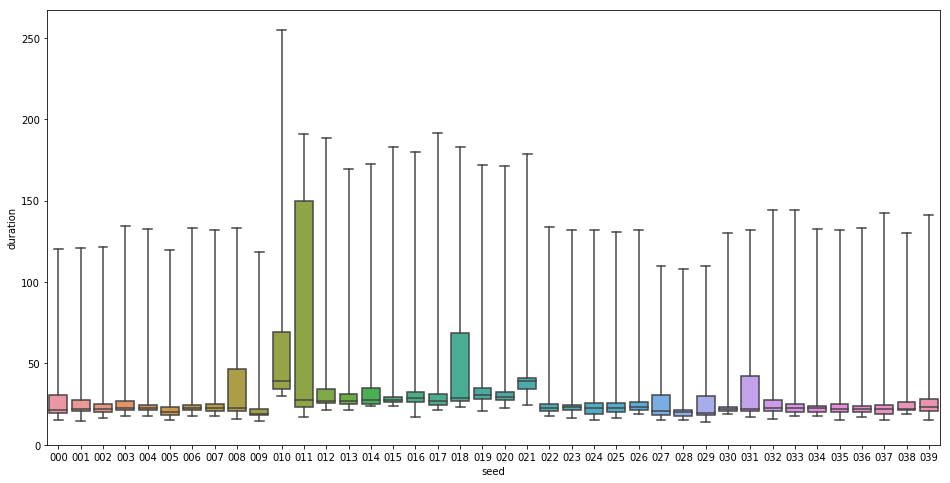

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="seed", y="duration", data=summary_df,
            whis="range", ax=ax)
ax.set_ylim(0, None)
fig.show()

In [9]:
clf_df = summary_df.melt(value_vars=['accepted', 'rejected', 'ignored'],
                         var_name='classification', value_name='n components',
                         id_vars=['label', 'failure'])
clf_df2 = summary_df.melt(value_vars=['accepted', 'rejected', 'ignored'],
                         var_name='classification', value_name='n components',
                         id_vars=['label'])
clf_df2['failure'] = 'Total'
df2 = pd.concat((clf_df, clf_df2))

/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



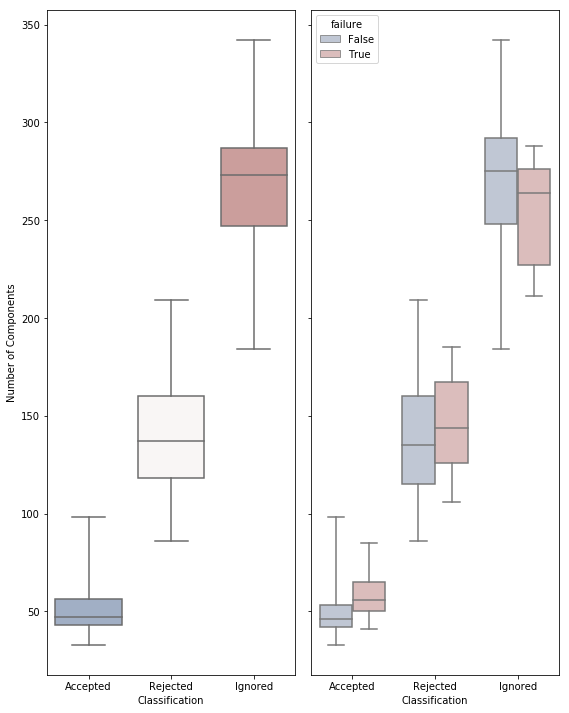

In [10]:
#sns.swarmplot(x='classification', y='n components', data=clf_df)
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(8, 10))
sns.boxplot(x="classification", y="n components", data=clf_df,
            whis="range", palette="vlag", ax=axes[0])

# Add in points to show each observation
#sns.swarmplot(x="classification", y="n components", data=clf_df,
#              size=5, color=".3", linewidth=0, ax=axes[0])

sns.boxplot(x="classification", y="n components", data=clf_df,
            whis="range", palette="vlag", ax=axes[1], hue='failure')

# Add in points to show each observation
#sns.swarmplot(x="classification", y="n components", data=clf_df,
#              size=5, color=".3", linewidth=0, ax=axes[1], hue='failure', dodge=True)

axes[0].set_ylabel('Number of Components')
axes[0].set_xlabel('Classification')
axes[1].set_xlabel('Classification')
axes[1].set_ylabel('')
axes[0].set_xticklabels([l.get_text().title() for l in axes[0].get_xticklabels()])

fig.tight_layout()
fig.show()

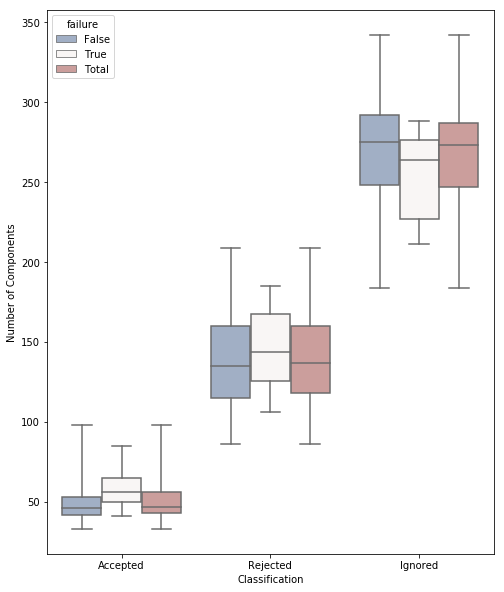

In [11]:
#sns.swarmplot(x='classification', y='n components', data=clf_df)
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="classification", y="n components", data=df2,
            whis="range", palette="vlag", hue='failure')

# Add in points to show each observation
#sns.swarmplot(x="classification", y="n components", hue='failure', data=df2,
#              size=5, color=".3", linewidth=0, dodge=True)

ax.set_ylabel('Number of Components')
ax.set_xlabel('Classification')
ax.set_xticklabels([l.get_text().title() for l in ax.get_xticklabels()])
fig.show()

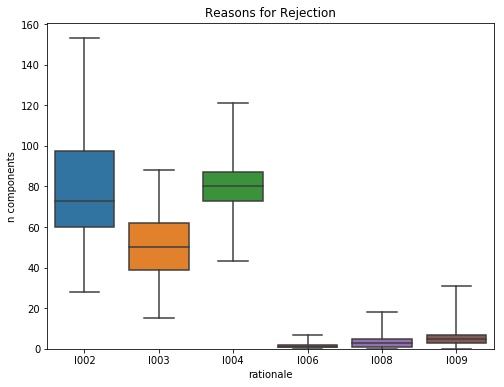

In [12]:
rej_df = summary_df.melt(value_vars=rej_codes, id_vars=['label', 'failure'],
                         value_name='n components', var_name='rationale')

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=rej_df, x='rationale', y='n components', whis='range', ax=ax)
ax.set_title('Reasons for Rejection')
ax.set_ylim(0, None)
fig.show()

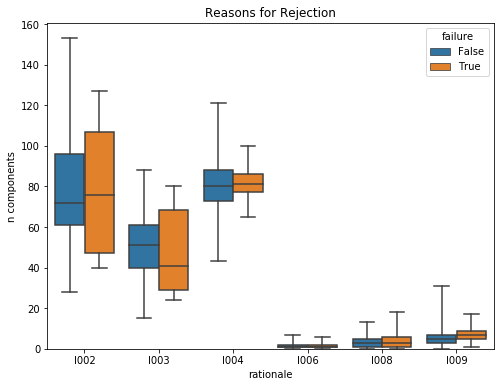

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=rej_df, x='rationale', y='n components', whis='range', ax=ax, hue='failure')
ax.set_title('Reasons for Rejection')
ax.set_ylim(0, None)
fig.show()

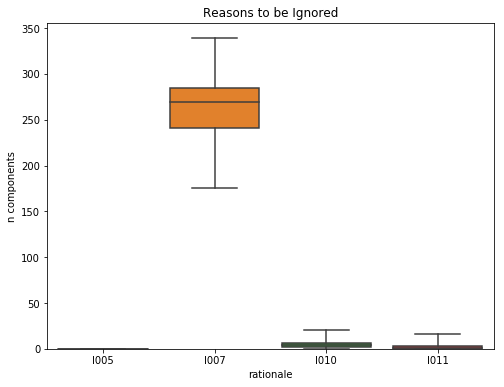

In [14]:
ign_df = summary_df.melt(value_vars=ign_codes, id_vars=['label', 'failure'],
                         value_name='n components', var_name='rationale')

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=ign_df, x='rationale', y='n components', whis='range', ax=ax)
ax.set_title('Reasons to be Ignored')
ax.set_ylim(0, None)
fig.show()

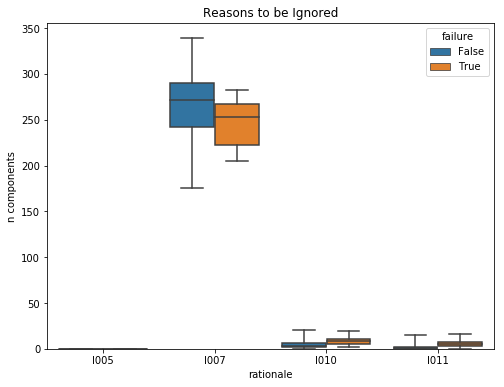

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=ign_df, x='rationale', y='n components', whis='range', hue='failure', ax=ax)
ax.set_title('Reasons to be Ignored')
ax.set_ylim(0, None)
fig.show()